### Install Libraries

In [40]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-01-21 02:53:30.596054: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /device:GPU:0 with 30990 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6348469263048768449,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 32496156672
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16064759019517881952
 physical_device_desc: "device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0"]

### 꽃 판별 CNN Keras

In [41]:
import os
print(os.listdir('./data/Flowers299'))

['Kniphofia', 'ForgetMeNot', 'Zinnia', 'IcelandPoppy', 'Pinks', 'Alchemilla', 'Lavatera', 'Nemophila', 'Linaria', 'Penstemon', 'Celosia', 'Phlox', 'FlannelFlower', 'Clover', 'Dahlia', 'Magnolia', 'Impatiens', 'Clematis', 'Mayflower', 'BabyтАЩsBreath', 'Lupin', 'TeaRose', 'Hosta', 'PersianButtercup', 'PaintedDaisy', 'Bluebonnets', 'ShastaDaisy', 'Geranium', 'Eremurus', 'Heliotrope', 'Photinia', 'Cornflower', 'RockRose', 'Viburnum', 'Hibiscus', 'Snowdrop', 'Silene', 'Dianella', 'Broom', 'Parodia', 'Xerophyllum', 'Quince', 'OrientalPoppy', 'Pansy', 'Columbine', 'Verbena', 'Helenium', 'Candytuft', 'WaxPlant', 'ArmeriaMaritima', 'Chrysanthemum', 'Bergamot', 'Lotus', 'LadyтАЩsSlipper', 'Sage', 'Marigold', 'TigerFlower', 'PincushionFlower', 'Alstroemeria', 'Sedum', 'PeaceLily', 'BalloonFlower', 'CaliforniaPoppy', 'LemonVerbena', 'Sunflower', 'MorningGlory', 'Bouvardia', 'Corydalis', 'PowderPuff', 'PassionFlower', 'Wedelia', 'Winterberry', 'CrownImperial', 'Bellflower', 'Feverfew', 'Clarkia', 

### Importing Various Modules

In [42]:
# warnings 처리를 위함
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [43]:
# 데이터 시각화를 위함
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

In [44]:
# model selection
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_curve, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [45]:
# preprocess
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [46]:
# keras 관련 라이브러리
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, RMSprop
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import random, os, PIL

In [47]:
# CNN 관련 모듈
from tensorflow.keras.layers import Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization

### Loading Dataset

In [48]:
labels = ['Abutilon', 'Acacia', 'Aconite', 'AfricanDaisy', 'Agapanthus', 'Ageratum', 'Alchemilla', 'Allium', 'Alstroemeria', 'Alyssum', 'Amaranthus', 'Amaryllis', 'Anemone', 'AniseHyssop', 'ArmeriaMaritima', 'Aster', 'Azalea', "Baby'sBreath", "Bachelor'sButton", 'BalloonFlower', 'Ballota', 'BeeBalm', 'Begonia', 'Bellflower', 'Bergamot', 'Bergenia', 'Billbergia', 'Black-eyedSusan', 'BlanketFlower', 'BlazingStar', 'BleedingHeart', 'Bletilla', 'Blue-eyedGrass', 'Bluebonnets', 'BluestarFlower', 'Borage', 'Bottlebrush', 'Bouvardia', 'Brachyscome', 'Brassica', 'Broom', 'Buttercup', 'ButterflyBush', 'Calceolaria', 'Calendula', 'CaliforniaPoppy', 'CallaLily', 'Camellia', 'Candytuft', 'CannaLily', 'CapeLeadwort', 'CapePrimrose', 'CardinalFlower', 'Carnation', 'Catharanthus', 'Catmint', 'Celosia', 'CerastiumTomentosum', 'Chicory', 'Chionodoxa', 'Chrysanthemum', 'Clarkia', 'Clematis', 'Clover', 'Columbine', 'Coneflower', 'CoralBells', 'CoralVine', 'Coreopsis', 'Cornflower', 'Corydalis', 'Cosmos', 'Cotoneaster', 'Crocosmia', 'Crocus', 'CrownImperial', 'CuckooFlower', 'Cyclamen', 'Daffodil', 'Dahlia', 'Daisy', 'Dandelion', 'Daphne', 'Daylily', 'Decumaria', 'Delphinium', 'DesertRose', 'Deutzia', 'Dianella', 'Dianthusbarbatus', 'Diascia', 'Dietes', 'Dill', 'Disa', 'DutchIris', 'Echinops', 'Echium', 'Elder', 'EnglishBluebell', 'Epimedium', 'Eremurus', 'Erica', 'Erigeron', 'Euphorbia', 'Eustoma', 'EveningPrimrose', 'FallCrocus', 'Feverfew', 'Firethorn', 'FlamingKaty', 'FlannelFlower', 'FlaxFlower', 'FloweringDogwood', 'ForgetMeNot', 'Forsythia', "FourO'clock", 'Foxglove', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Fuchsia', 'Gaillardia', 'Gardenia', 'Gazania', 'Geranium', 'GerberaFlower', 'Gladiolas', 'Goldenrod', 'GrapeHyacinth', 'Guzmania', 'Hawthorn', 'Heather', 'Hebe', 'Helenium', 'Helichrysum', 'Heliotrope', 'Hellebore', 'Hibiscus', 'Holly', 'Hollyhock', 'Honeysuckle', 'Hosta', 'Hyacinth', 'Hydrangea', 'Hyssop', 'IcelandPoppy','IcePlant', 'Impatiens', 'IpomoeaLobata', 'Iris', 'Ixia', 'Ixora', "Jacob'sLadder", 'Jasmine', 'JohnnyJumpUp', 'KaffirLily', 'Kalmia', 'KangarooPaw', 'Knautia', 'Kniphofia', "Lady'sSlipper", 'Laelia', 'Lantana', 'Larkspur', 'Lavatera', 'Lavender', 'LemonVerbena', 'Lewesia', 'Lilac', 'Lily', 'LilyoftheValley', 'Linaria', 'Lotus', 'LoveintheMist', 'Lunaria', 'Lupin', 'Magnolia', 'MalteseCross', 'Mandevilla', 'MargueriteDaisy', 'Marigold', 'Matthiola', 'Mayflower', 'Meconopsis', 'Mimosa', "Monk'sHood", 'MoonflowerVine', 'Moraea', 'MorningGlory', 'MossRose', 'Narcissus', 'Nasturtium', 'Nemesia', 'Nemophila', 'Neoregelia', 'Nerine', 'NewZealandTeaTree', 'Nierembergia', 'Nolana', 'Oleander', 'Olearia', 'Orchid', 'OrientalLily', 'OrientalPoppy', 'OrnamentalCherry', 'Ornithogalum', 'Osteospermum', 'Oxalis', 'OxeyeDaisy', 'OysterPlant', 'PaintedDaisy', 'Pansy', 'Parodia', 'PassionFlower', 'PeaceLily', 'Pelargonium', 'Penstemon', 'Peony', 'Periwinkle', 'PersianButtercup', 'Petunia', 'Phlox', 'Photinia', 'Physostegia', 'PincushionFlower', 'Pinks', 'Poinsettia', 'Polyanthus', 'Poppy', 'Potentilla', 'PowderPuff', 'QuakerLadies', "Queen'sCup", 'QueenoftheMeadow', 'Quince', 'RainLily', 'RockRose', 'Rondeletia', 'RoseofSharon', 'Roses', 'Sage', 'SaintJohn_셲Wort', 'Scaevola', 'ScentedGeranium', 'Scilla', 'Sedum', 'ShastaDaisy', 'Silene', 'Snapdragon', 'Snowdrop', 'Snowflake', 'Soapwort', 'Speedwell', 'Starflower', 'Statice', 'Sunflower', 'SweetPea', 'TeaRose', 'TigerFlower', 'Tithonia', 'TobaccoPlant', 'Trachelium', 'Trillium', 'Triteleia', 'Tritoniacrocata', 'Trollius', 'TrumpetVine', 'Tuberose', 'Tulip', 'UrnPlant', 'Ursinia', 'UvaUrsi', 'Valerian', 'Verbena', 'Viburnum', 'Viola', 'VirginiaCreeper', 'Wallflower', 'Wandflower', 'Waterlilies', 'Watsonia', 'WaxPlant', 'Wedelia', 'Weigela', 'WhirlingButterflies', 'Winterberry', 'WinterJasmine', 'WishboneFlower', 'WoollyViolet', 'Xanthocerassorbifolium', 'Xerophyllum', 'Xylobium', 'Xylosma', 'Yarrow', 'Yellow-eyedGrass', 'YellowArchangel', 'YellowBell', 'Zenobia', 'Zinnia']

In [49]:
import tensorflow as tf

tf.__version__


'2.6.0-rc0'

In [50]:
train_generator = tf.keras.utils.image_dataset_from_directory(
  './data/Flowers299',
  image_size=(180, 180),
  batch_size=32)

Found 115944 files belonging to 299 classes.


In [51]:
class_names = train_generator.class_names

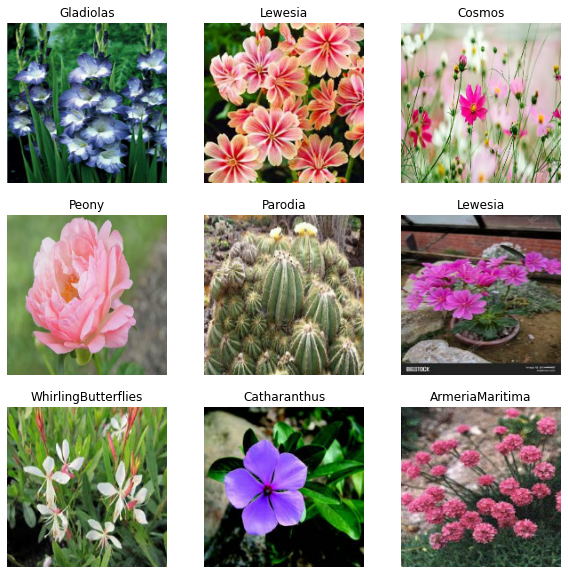

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [53]:
for image_batch, labels_batch in train_generator:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [54]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_generator.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [55]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [56]:
normalized_ds = train_generator.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [57]:
train_ds

<PrefetchDataset shapes: ((None, 180, 180, 3), (None,)), types: (tf.float32, tf.int32)>

In [59]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (180,180,3)))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5, activation = "softmax"))

TypeError: normalize_tuple() got an unexpected keyword argument 'allow_zero'

In [ ]:
model.compile(
  optimizer='adam',
  loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

In [ ]:
model.fit(
  train_ds,
  epochs=3
)